# Query Domain Classification
Build a system to categorize the query on the basis of the domain using Natural Language Processing.

**Problem Statement**

DSForum is a community-based portal where users can post queries related to data science topics such as machine learning, statistical analysis, data visualization, etc. The company optimizes the response time of the query by answering the query to the earliest. Nevertheless, the community can answer the queries through discussion forums. The queries might be related to different domains like Techniques, Tools, Careers, etc. 

Currently, the users manually tag the queries while posting the query into any of these categories: Techniques, Tools, Career, Hackathons, Resources, Misc, or Other. The query is then forwarded to the concerned team. This process is more error-prone and impacts the query response time. 

Can we design and develop a model that can accurately classify queries based on their domain? This will help the team to improve the response time of the platform by accurately identifying the domain of a query and redirecting it to the appropriate team and resolving the queries to the earliest. 

**Data Dictionary**

You are provided with 3 files - train.csv, test.csv, and sample_submission.csv

*Train and Test Set*

The train and test set contains the queries from different timespans. The train set includes the target variable ‘domain’ whereas in the test set, you need to predict the target variable ‘domain’. The target variable category contains multiple classes like Techniques, Tools, Career, Hackathons, Resources, Misc, Other.

| Variable | Description                           |
|----------|---------------------------------------|
| ID       | Unique identifier of the query        |
| Title    | Title of the query                    |
| Domain   | Domain of the query (Target Variable) |


*Submission File Format*

The solution file should follow a format similar to that of the sample submission file. sample_submission.csv contains 2 variables - ID and Domain.

| Variable | Description                    |
|----------|--------------------------------|
| ID       | Unique identifier of the query |
| Domain   | Domain of the query            |

**Evaluation metric**

The evaluation metric for this hackathon would be Macro F1 Score.

**Public and Private Split**

Test data is further divided into Public (40%) and Private (60%) data. Your initial responses will be checked and scored on the Public data. The final rankings would be based on your private score which will be published once the competition is over.

**Guidelines for Final Submission**

Please ensure that your final submission includes the following:
1. Solution file containing the predictions for the ID in the test set (Format is given in sample_submission.csv)
2. A zipped file containing code & approach
    * Code: Clean code with comments on each part
    * Approach: Please share your approach to solve the problem (doc/ppt/pdf format). It should cover the following topics:
        * A brief on the approach used to solve the problem. 
        * Which Data-preprocessing / Feature Engineering ideas really worked? 
        * How does your final model look like? How did you reach it?


**Rules and Conditions**

1. The final standings would be based on the private leaderboard score.
2. Setting the final submission is recommended. Without a final submission, the submission corresponding to the best public score will be taken as the final submission
3. Use of external data is not allowed.
4. The submitted code file must be able to reproduce a similar score to that of the final submission file.
5. The code file pertaining to your final submission is mandatory while setting final submission.
6. Entries submitted after the contest is closed, will not be considered
7. Throughout the hackathon, you are expected to respect fellow hackers and act with high integrity.
8. Use of multiple Login IDs will lead to immediate disqualification
9. Analytics Vidhya holds the right to disqualify any participant at any stage of the competition if the participant(s) are deemed to be acting fraudulently.

### Load the Workspace

In [64]:
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from spacy.tokens import Doc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import normalize, FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, f1_score, make_scorer
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MaxAbsScaler

### Load the data

In [2]:
train = pd.read_csv('train_3.csv')
test = pd.read_csv('test_ZUT1mqB.csv')
sample = pd.read_csv('sample_submission_1_mh4j3tR.csv')

In [3]:
train.head()

,ID,Title,Domain
0,1,"What is good in a decision tree, a large or a ...",Techniques
1,2,Training data only contains single positive label,Techniques
2,3,Calculating percentage contribution of a negat...,Techniques
3,4,Unable to open solution checker!,Hackathons
4,5,User Name Change,Misc


In [4]:
test.head()

,ID,Title
0,3846,Spark Cheatsheet
1,3847,Review of Random forest code in Python
2,3848,Chi-Sq Test for Numeric variables
3,3849,Prediction from loaded pickled file for single...
4,3850,"Even after installing Anaconda on my PC, I am ..."


In [5]:
sample.head()

,ID,Domain
0,3846,Tools
1,3847,Tools
2,3848,Tools
3,3849,Tools
4,3850,Tools


### Data Exploration

In [6]:
train.iloc[0]

ID                                                        1
Title     What is good in a decision tree, a large or a ...
Domain                                           Techniques
Name: 0, dtype: object

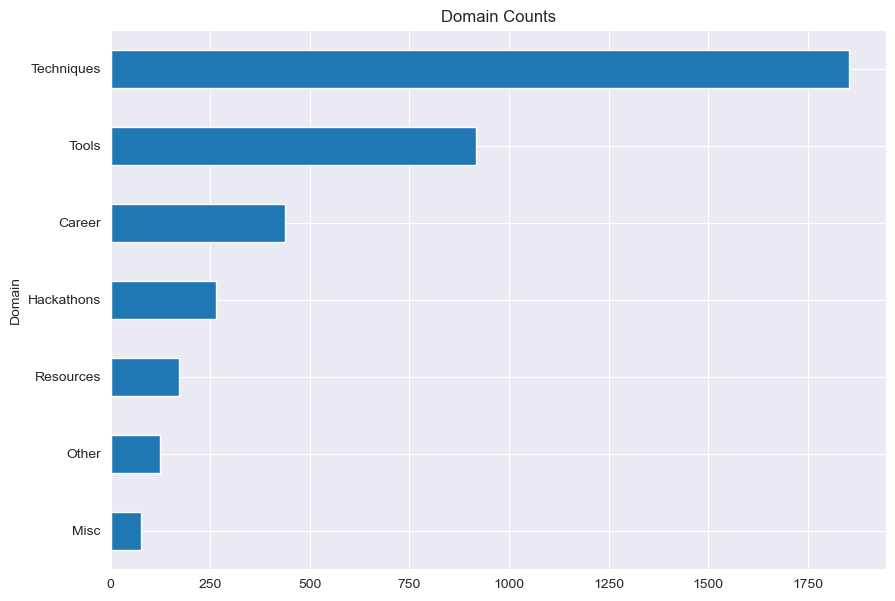

In [7]:
train.Domain.value_counts(dropna=False).plot(kind='barh',stacked=True,figsize=(10,7), title='Domain Counts')
plt.gca().invert_yaxis()

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3845 entries, 0 to 3844
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3845 non-null   int64 
 1   Title   3834 non-null   object
 2   Domain  3845 non-null   object
dtypes: int64(1), object(2)
memory usage: 90.2+ KB


**Drop Missing Values**

In [9]:
train.loc[train.Title.isna()]

,ID,Title,Domain
438,439,NaN,Resources
771,772,NaN,Misc
794,795,NaN,Hackathons
927,928,NaN,Misc
1265,1266,NaN,Other
1425,1426,NaN,Resources
2199,2200,NaN,Hackathons
2364,2365,NaN,Career
2663,2664,NaN,Other
3472,3473,NaN,Other


In [10]:
train = train.drop(index=train.loc[train.Title.isna()].index)

### Feature Engineering

**Split into Training and Validation Set**

In [11]:
X, y = train.Title, train.Domain

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=42)

print("type of X_train: {}".format(type(X_train)))
print("length of X_train: {}".format(len(X_train)))
print("X_train[6]:\n{}".format(X_train.iloc[6]))

type of X_train: <class 'pandas.core.series.Series'>
length of X_train: 2683
X_train[6]:
Data analytics /data science career after 2yrs break


**Samples Per Class in Training Set**

In [12]:
np.unique(y_train)

array(['Career', 'Hackathons', 'Misc', 'Other', 'Resources', 'Techniques',
       'Tools'], dtype=object)

In [13]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform text classes to numerical labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Get counts of each numerical label using np.bincount()
print("Samples per class (training): {}".format(np.bincount(y_train_encoded)))

Samples per class (training): [ 295  186   53   82  115 1319  633]


**Representing the Queries as Bag of Words**

When we engineer the training features into bag of words for modeling, the shape of the X_train_vect variable, the bag-of-words representation of the training data is 2683x3288, indicating that the vocabulary contains 3288 entries. The data is stored as a SciPy sparse matrix.

In [14]:
vect = CountVectorizer().fit(X_train)
X_train_vect = vect.transform(X_train)
X_val_vect = vect.transform(X_val)
print("X_train_vect:\n{}".format(repr(X_train_vect)))

X_train_vect:
<2683x3288 sparse matrix of type '<class 'numpy.int64'>'
	with 20182 stored elements in Compressed Sparse Row format>


We'll access the vocabulary by using the get_feature_name method of the vectorizer, which returns a convenient list where each entry corresponds to one feature:

In [15]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 210 to 230:\n{}".format(feature_names[210:230]))
print("Every 200th feature:\n{}".format(feature_names[::200]))

Number of features: 3288
First 20 features:
['000' '00000' '04' '10' '100' '1000' '10000' '101' '12' '13' '14' '140'
 '14th' '15' '1598' '16' '19' '1970' '1999' '1st']
Features 210 to 230:
['argv' 'arima' 'arithmetica' 'arma' 'armed' 'arr' 'arrange' 'array'
 'arrays' 'arrive' 'art' 'article' 'artificial' 'as' 'ascertaining'
 'ascii' 'ask' 'asking' 'asks' 'aspects']
Every 200th feature:
['000' 'april' 'breadth' 'competition' 'defining' 'energy' 'forums' 'hsd'
 'july' 'matchbox' 'note' 'politics' 'realiably' 'screening' 'stats'
 'transferring' 'week']


Modeling with Logistic Regression:

Let’s start by evaluating Logistic Regression using cross-validation. The scoring method is f1 macro:

In [16]:
scorer = make_scorer(f1_score, average='macro')
f1_scores = cross_val_score(LogisticRegression(max_iter=1000), X_train_vect, y_train, cv=5, scoring=scorer)

formatted_scores = [f'{score:.2f}' for score in f1_scores]
formatted_mean_score = f'{f1_scores.mean():.2f}'

print("F1 scores for each fold:", formatted_scores)
print("Mean F1 macro score:", formatted_mean_score)

F1 scores for each fold: ['0.42', '0.44', '0.37', '0.42', '0.44']
Mean F1 macro score: 0.42


We have an F1 macro score of 42% indicates moderate performance. Generally, an F1 score of 42% suggests that the model's precision and recall across the classes, when averaged, are relatively low to moderate. This may imply that the model might have some difficulties in correctly identifying certain classes or has imbalanced performance across different classes.


**Precision-Recall Analysis**
Let's plot the precision-recall curve to understand this better. This is relevant since the F1 Score is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. 

Precision measures the accuracy of the positive predictions made by the model, by answering the question: "Of all the instances predicted as positive, how many were actually positive?" A high precision means that when the model predicts an instance as positive, it is usually correct.

Recall measures the model's ability to correctly identify all positive instances by answering the question: "Of all the actual positive instances, how many were correctly predicted as positive?" It calculates the proportion of correctly predicted positive cases out of all actual positive instances. A high recall means that the model can effectively identify most of the positive cases.

Precision focuses on the accuracy of positive predictions among all predicted positives. Recall focuses on the coverage of positive instances among all actual positives.

From our Precision-Recall curve plot, precision is mid to high among all classes except `Resources`, `Other` and `Misc`. This may be related to the fact that these classes are the least represented in the dataset.

With our BoW logistic regression model, the model is significantly able to accurately predict `Career` and `Techniques` classes and is moderately able to accurately predict `Tools` and `Hackathons`.

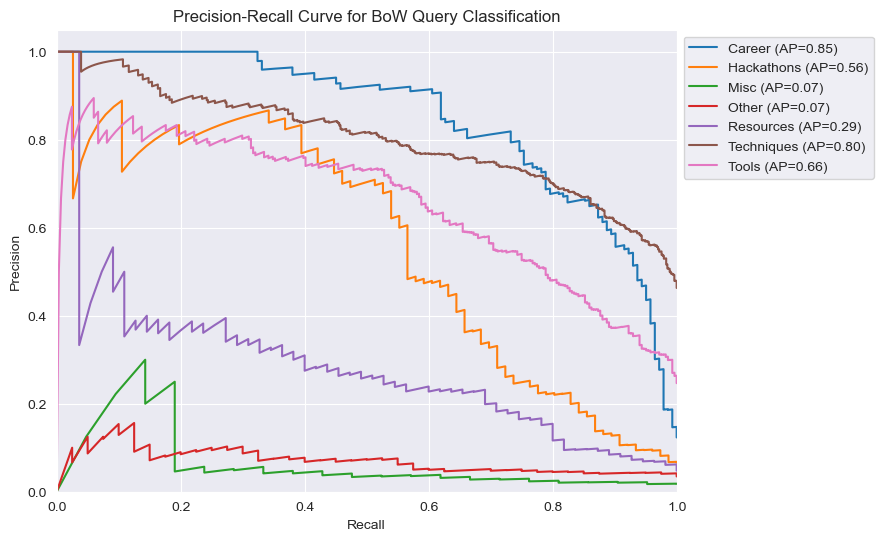

In [17]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vect, y_train)

# Predict probabilities for each class in the test set
y_scores = clf.predict_proba(X_val_vect)

# Binarize the labels
y_test_bin = label_binarize(y_val, classes=np.unique(y_val))

# Compute precision-recall curve and average precision score for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(clf.classes_.size):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_scores[:, i])

# Plot precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i, class_ in enumerate(clf.classes_):
    plt.plot(recall[i], precision[i], label=f'{class_} (AP={average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for BoW Query Classification')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


Hyper-Parameter Tuning on the Logistic Regression Model

In [18]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring=scorer)
grid.fit(X_train_vect, y_train)

print("Best cross-validation F1-Macro score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation F1-Macro score: 0.43
Best parameters:  {'C': 10}


F1-Macro score slightly increases when we use a `C` value of 10.

**Improving Word Extraction**

We'll reduce the token extraction to token that appear in a minimum of 5 queries:

Reducing the number of features reduces the F1 Macro Score.

In [19]:
vect = CountVectorizer(min_df=5).fit(X_train)
X_train_vect = vect.transform(X_train)
X_val_vect = vect.transform(X_val)
print("X_train with min_df: {}".format(repr(X_train_vect)))

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring=scorer)
grid.fit(X_train_vect, y_train)

print("Best cross-validation F1-Macro score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

X_train with min_df: <2683x669 sparse matrix of type '<class 'numpy.int64'>'
	with 16028 stored elements in Compressed Sparse Row format>
Best cross-validation F1-Macro score: 0.41
Best parameters:  {'C': 1}


**Using Stop-words**

This discards words that are too frequent to be informative.

In [20]:
vect = CountVectorizer(min_df=5, stop_words="english").fit(X_train)
X_train_vect = vect.transform(X_train)
X_val_vect = vect.transform(X_val)
print("X_train with min_df: {}".format(repr(X_train_vect)))

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring=scorer)
grid.fit(X_train_vect, y_train)

print("Best cross-validation F1-Macro score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

X_train with min_df: <2683x573 sparse matrix of type '<class 'numpy.int64'>'
	with 9259 stored elements in Compressed Sparse Row format>
Best cross-validation F1-Macro score: 0.41
Best parameters:  {'C': 10}


**Rescaling the Data with tf-idf**

Instead of dropping features that are deemed unimportant, another approach is to rescale features by how informative we expect them to be. One of the most common ways to do this is using the term frequency–inverse document frequency (tf–idf) method. If a word appears often in a particular document, but not in very many documents, it is likely to be very descriptive of the content of that document.

In [21]:
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(max_iter=2000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring=scorer)
grid.fit(X_train, y_train)
print("Best cross-validation F1-Macro score: {:.2f}".format(grid.best_score_))

Best cross-validation F1-Macro score: 0.40


Let's inspect which words tf–idf found most important:

In [22]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]

# transform the training dataset:
X_train_vect = vectorizer.transform(X_train)

# find maximum value for each of the features over dataset:
max_value = X_train_vect.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['how' 'regression' 'machine' 'use' 'which' 'between' 'help' 'while' 'be'
 'classification' 'prediction' 'we' 'does' 'why' 'difference' 'when'
 'find' 'need' 'big' 'algorithm']
Features with highest tfidf: 
['sql' 'year' 'study' 'time' 'row' 'encoding' 'estimate' 'survival'
 'shape' 'cv' 'test' 'loop' 'objects' 'implementing' 'standard' 'squared'
 'business' 'nlp' 'h2o' 'bar']


**Bag of words with more than one word (n-grams)**

There is a way of capturing context when using a bag-of-words representation, by not only considering the counts of single tokens, but also the counts of pairs or triplets of tokens that appear next to each other. Pairs of tokens are known as bigrams, triplets of tokens are known as trigrams, and more generally sequences of tokens are known as n-grams.

In [23]:
pipe = make_pipeline(
    TfidfVectorizer(min_df=5), LogisticRegression(max_iter=2000)
)
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100], "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring=scorer)
grid.fit(X_train, y_train)
print("Best cross-validation F1-Macro score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation F1-Macro score: 0.41
Best parameters:
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 1)}


From the heatmap we can see that using bigrams and trigrams reduce performance.

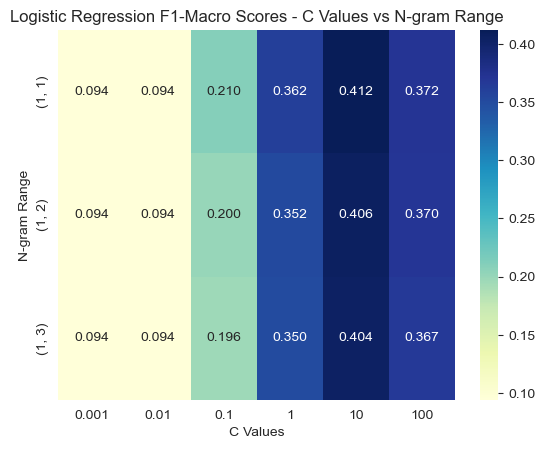

In [24]:
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T

sns.heatmap(
    scores, cmap="YlGnBu", annot=True, fmt=".3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range']
)
plt.ylabel('N-gram Range')
plt.xlabel('C Values')
plt.title('Logistic Regression F1-Macro Scores - C Values vs N-gram Range')
plt.show()

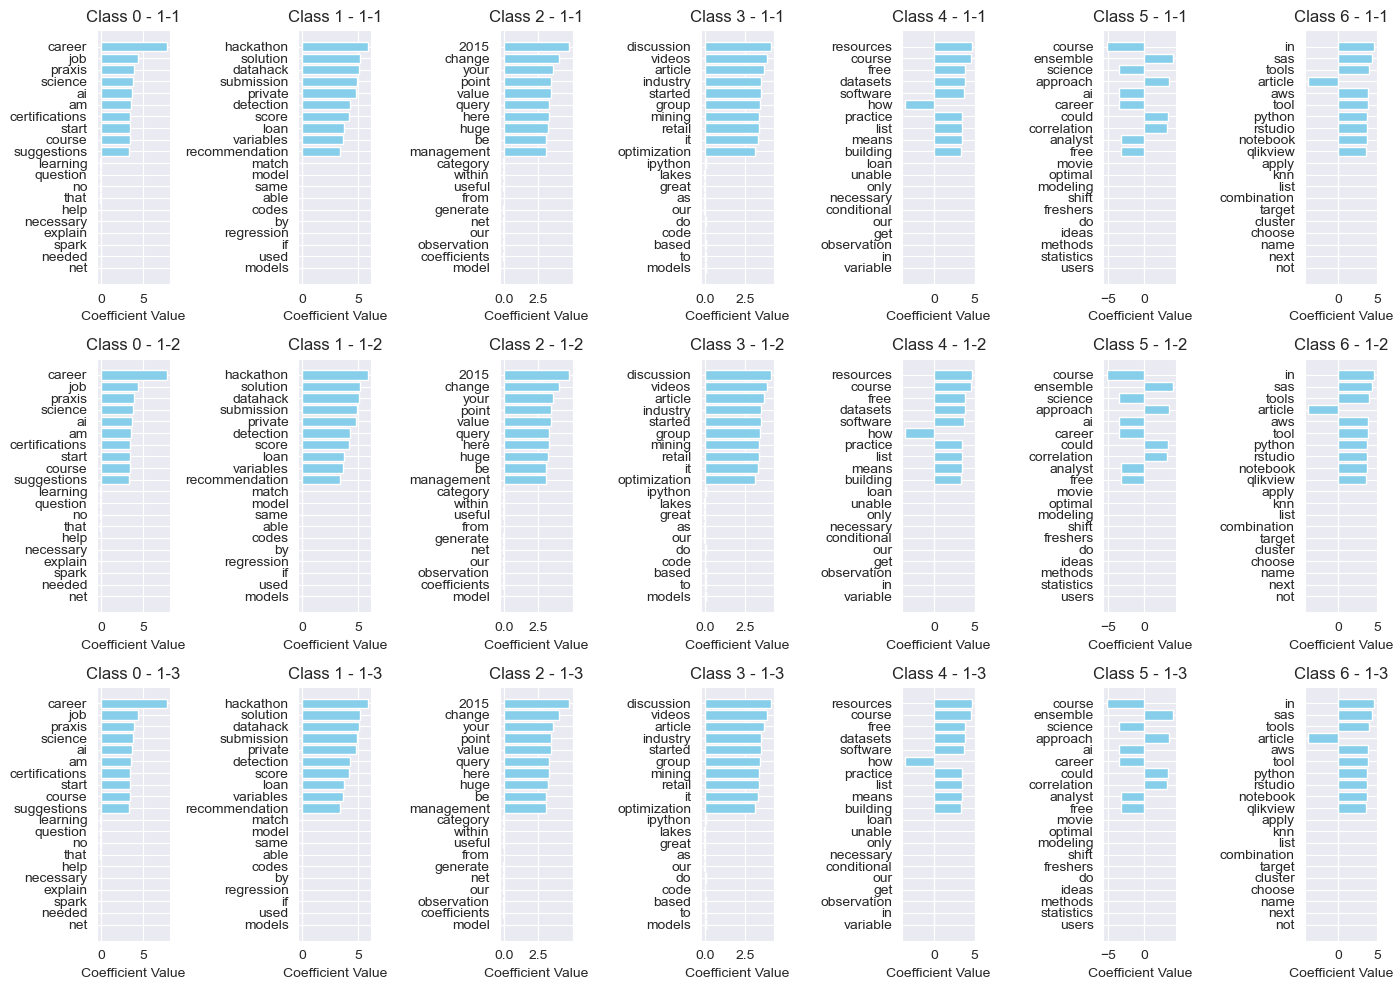

In [25]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names_out())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_

# Define n-gram ranges
ngram_ranges = [(1, 1), (1, 2), (1, 3)]  # Unigrams, bigrams, and trigrams

# Plot coefficients for each class separately
plt.figure(figsize=(14, 10))
for i, ngram_range in enumerate(ngram_ranges):
    for class_index in range(coef.shape[0]):
        rel_coef = coef[class_index]
        # Sort coefficients indices based on absolute value to get top features
        sorted_indices = np.argsort(np.abs(rel_coef))
        top_indices = np.concatenate((sorted_indices[:10], sorted_indices[-10:]))

        # Plot important coefficients for each class and n-gram range
        plt.subplot(len(ngram_ranges), coef.shape[0], i * coef.shape[0] + class_index + 1)
        plt.barh(range(len(top_indices)), rel_coef[top_indices], color='skyblue')
        plt.yticks(range(len(top_indices)), feature_names[top_indices])
        plt.title(f'Class {class_index} - {ngram_range[0]}-{ngram_range[1]}')
        plt.xlabel('Coefficient Value')

plt.tight_layout()
plt.show()

**Advanced tokenization, stemming and lemmatization**

Tokenization is the process of breaking down text into smaller units called tokens. These tokens can be words, phrases, sentences, or even characters, depending on the granularity required for analysis. It defines what constitutes a word for the purpose of feature extraction.

Stemming is the process of reducing words to their root or base form (stem) by removing suffixes. It aims to reduce words to a common base form, even if the stem itself is not a valid word.

Lemmatization is similar to stemming but aims to obtain the base or dictionary form of a word (known as the lemma) by considering the word's context and meaning. Unlike stemming, lemmatization ensures that the root word obtained is a valid word present in the language.

Both processing methods, lemmatization and stemming, are forms of normalization that try to extract some normal form of a word. Another interesting case of normalization is spelling correction.

In [26]:
# regexp used in CountVectorizer:
regexp = re.compile('(?u)\\b\\w\\w+\\b')
# load spacy language model
en_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# replace the tokenizer with the preceding regexp
en_nlp.tokenizer = lambda string: Doc(en_nlp.vocab, words=regexp.findall(string))

# create a custom tokenizer using the SpaCy document processing pipeline (now using our own tokenizer)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

In [27]:
# define a count vectorizer with the custom tokenizer
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)
X_train_vect = lemma_vect.fit_transform(X_train)
X_val_vect = lemma_vect.transform(X_val)
print("X_train with min_df: {}".format(repr(X_train_vect)))

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(LogisticRegression(max_iter=2000), param_grid, cv=5, scoring=scorer)
grid.fit(X_train_vect, y_train)

print("Best cross-validation F1-Macro score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X_train with min_df: <2683x637 sparse matrix of type '<class 'numpy.int64'>'
	with 16701 stored elements in Compressed Sparse Row format>
Best cross-validation F1-Macro score: 0.41
Best parameters:  {'C': 1}


Lemmatization reduced the number of features by 30. Lemmatization can be seen as a kind of regularization, as it conflates certain features. Therefore, we expect lemmatization to improve performance most when the dataset is small.

In [28]:
X_train_vect = lemma_vect.fit_transform(X_train)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99, train_size=0.01, random_state=0)

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=cv, scoring=scorer)
grid.fit(X_train_vect, y_train)

print("Best cross-validation F1-Macro score: {:.3f}".format(grid.best_score_))

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Best cross-validation F1-Macro score: 0.173


Using l2 Normalized Features on BoW:

In [29]:
vect = CountVectorizer().fit(X_train)
X_train_vect = normalize(vect.transform(X_train), axis=0)
X_val_vect = normalize(vect.transform(X_val), axis=0)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(LogisticRegression(max_iter=2000), param_grid, cv=5, scoring=scorer)
grid.fit(X_train_vect, y_train)

print("Best cross-validation F1-Macro score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation F1-Macro score: 0.40
Best parameters:  {'C': 100}


Stemming:

In [30]:
# Initialize Porter Stemmer
stemmer = PorterStemmer()

# Custom tokenizer function with stemming
def custom_tokenizer_stemming(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Apply stemming to each word token using Porter Stemmer
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    return stemmed_tokens

In [31]:
stem_vect = TfidfVectorizer(tokenizer=custom_tokenizer_stemming)
X_train_vect = stem_vect.fit_transform(X_train)
X_val_vect = stem_vect.transform(X_val)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(LogisticRegression(max_iter=2000), param_grid, cv=5, scoring=scorer)
grid.fit(X_train_vect, y_train)

print("Best cross-validation F1-Macro score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Best cross-validation F1-Macro score: 0.44
Best parameters:  {'C': 10}


The best model on the Logistic Regression uses the stemming parameters with an F1-Macro Score of 44%.

**Trying Other Models**

We'll use class weight balancing with the new models to attempt to increase the F1-Macro score.

In [32]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary of class weights
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Calculate class priors from class weights
class_priors = class_weights / len(y_train)

# Create a dictionary of class priors
class_prior_dict = dict(zip(np.unique(y_train), class_priors))

In [33]:
lr = LogisticRegression(max_iter=2000, class_weight=class_weight_dict)
sgd_clf = SGDClassifier(max_iter=2000, class_weight=class_weight_dict)
linear_svc = LinearSVC(max_iter=2000, class_weight=class_weight_dict)
svc = SVC(max_iter=2000, class_weight=class_weight_dict)
tree_clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, class_weight=class_weight_dict)
rf_clf = RandomForestClassifier(max_depth=4, min_samples_leaf=5, class_weight=class_weight_dict)
et_clf = ExtraTreesClassifier(max_depth=4, min_samples_leaf=5, class_weight=class_weight_dict)
gb_clf = GradientBoostingClassifier(max_depth=4, min_samples_leaf=5)
knn_clf = KNeighborsClassifier(n_neighbors=5)
nb_clf = MultinomialNB()

xgb = XGBClassifier()

In [34]:
feature_descriptions = ['BoW', 'BoW-Stopwords', 'l2_BoW', 'TfidVectorizer', 'Lemmatization', 'Stemming']

model_names = ['LogisticRegression', 'SGDClassifier', 'LinearSVC', 'SVC', 'DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'KNeighborsClassifier', 'NaiveBayesClassifier']

models = [lr, sgd_clf, linear_svc, svc, tree_clf, rf_clf, et_clf, gb_clf, knn_clf, nb_clf]

In [35]:
def simple_classifier_cross_val(
        model, X_train, y_train, description,
):
    ## Helper function to train a classifier with cross-validation
    scorer = make_scorer(f1_score, average='macro')
    f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)
    formatted_scores = [f'{score:.2f}' for score in f1_scores]
    formatted_mean_score = f'{f1_scores.mean():.2f}'

    print("F1 scores for each fold with", description, "features:", formatted_scores)
    print("Mean F1 macro score:", formatted_mean_score)

In [36]:
def simple_classifier(
        model, X_train, y_train, X_test, y_test, description,
):
    ## Helper function to train a classifier and score on test data
    m = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    s = f1_score(y_test, y_pred, average='macro')
    print ('Test F1 Macro score with', description, 'features:', format(s, '.3f'))
    return m

In [37]:
for feature in feature_descriptions:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if 'Stopwords' in feature:
            vect = CountVectorizer(min_df=5, stop_words="english").fit(X_train)
            X_train_vect = vect.transform(X_train)
            X_val_vect = vect.transform(X_val)
        elif 'l2' in feature:
            vect = CountVectorizer().fit(X_train)
            X_train_vect = normalize(vect.transform(X_train), axis=0)
            X_val_vect = normalize(vect.transform(X_val), axis=0)
        elif 'Vectorizer' in feature:
            vect = TfidfVectorizer(norm=None).fit(X_train)
            X_train_vect = vect.transform(X_train)
            X_val_vect = vect.transform(X_val)
        elif 'Lemmatization' in feature:
            def custom_tokenizer(text):
                doc_spacy = en_nlp(text)
                return [token.lemma_ for token in doc_spacy]
            vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)
            X_train_vect = vect.fit_transform(X_train)
            X_val_vect = vect.transform(X_val)
        elif 'Stemming' in feature:
            def custom_tokenizer(text):
                stemmer = PorterStemmer()
                tokens = word_tokenize(text)
                stemmed_tokens = [stemmer.stem(word) for word in tokens]
                return stemmed_tokens
            vect = TfidfVectorizer(tokenizer=custom_tokenizer)
            X_train_vect = vect.fit_transform(X_train)
            X_val_vect = vect.transform(X_val)
        else:
            vect = CountVectorizer().fit(X_train)
            X_train_vect = vect.transform(X_train)
            X_val_vect = vect.transform(X_val)

        for model, model_name in zip(models, model_names):
            print(model_name)
            try:
                simple_classifier_cross_val(
                    model, X_train_vect, y_train, feature
                )
            except TypeError as e:
                print(e)
        print('\n')
        

LogisticRegression
F1 scores for each fold with BoW features: ['0.44', '0.47', '0.38', '0.46', '0.47']
Mean F1 macro score: 0.45
SGDClassifier
F1 scores for each fold with BoW features: ['0.40', '0.47', '0.38', '0.43', '0.45']
Mean F1 macro score: 0.43
LinearSVC
F1 scores for each fold with BoW features: ['0.42', '0.49', '0.37', '0.45', '0.47']
Mean F1 macro score: 0.44
SVC
F1 scores for each fold with BoW features: ['0.39', '0.43', '0.35', '0.44', '0.42']
Mean F1 macro score: 0.41
DecisionTreeClassifier
F1 scores for each fold with BoW features: ['0.20', '0.17', '0.17', '0.16', '0.20']
Mean F1 macro score: 0.18
RandomForestClassifier
F1 scores for each fold with BoW features: ['0.32', '0.36', '0.33', '0.32', '0.37']
Mean F1 macro score: 0.34
ExtraTreesClassifier
F1 scores for each fold with BoW features: ['0.37', '0.34', '0.33', '0.32', '0.36']
Mean F1 macro score: 0.34
GradientBoostingClassifier
F1 scores for each fold with BoW features: ['0.41', '0.39', '0.35', '0.38', '0.44']
Mean 

With cross-validation, the best model is the l2-Normalized and Stemming Logistic Regression models with 46% average f1 Macro score. Overall, linear models with stemming features performed best.

In [38]:
for feature in feature_descriptions:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if 'Stopwords' in feature:
            vect = CountVectorizer(min_df=5, stop_words="english").fit(X_train)
            X_train_vect = vect.transform(X_train)
            X_val_vect = vect.transform(X_val)
        elif 'l2' in feature:
            vect = CountVectorizer().fit(X_train)
            X_train_vect = normalize(vect.transform(X_train), axis=0)
            X_val_vect = normalize(vect.transform(X_val), axis=0)
        elif 'Vectorizer' in feature:
            vect = TfidfVectorizer(norm=None).fit(X_train)
            X_train_vect = vect.transform(X_train)
            X_val_vect = vect.transform(X_val)
        elif 'Lemmatization' in feature:
            def custom_tokenizer(text):
                doc_spacy = en_nlp(text)
                return [token.lemma_ for token in doc_spacy]
            vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)
            X_train_vect = vect.fit_transform(X_train)
            X_val_vect = vect.transform(X_val)
        elif 'Stemming' in feature:
            def custom_tokenizer(text):
                stemmer = PorterStemmer()
                tokens = word_tokenize(text)
                stemmed_tokens = [stemmer.stem(word) for word in tokens]
                return stemmed_tokens
            vect = TfidfVectorizer(tokenizer=custom_tokenizer)
            X_train_vect = vect.fit_transform(X_train)
            X_val_vect = vect.transform(X_val)
        else:
            vect = CountVectorizer().fit(X_train)
            X_train_vect = vect.transform(X_train)
            X_val_vect = vect.transform(X_val)
    
        for model, model_name in zip(models, model_names):
            print(model_name)
            try: 
                simple_classifier(
                    model, X_train_vect, y_train, X_val_vect, y_val, feature
                )
            except TypeError as e:
                print(e)
        print('\n')
        

LogisticRegression
Test F1 Macro score with BoW features: 0.433
SGDClassifier
Test F1 Macro score with BoW features: 0.398
LinearSVC
Test F1 Macro score with BoW features: 0.411
SVC
Test F1 Macro score with BoW features: 0.399
DecisionTreeClassifier
Test F1 Macro score with BoW features: 0.186
RandomForestClassifier
Test F1 Macro score with BoW features: 0.346
ExtraTreesClassifier
Test F1 Macro score with BoW features: 0.412
GradientBoostingClassifier
Test F1 Macro score with BoW features: 0.399
KNeighborsClassifier
Test F1 Macro score with BoW features: 0.317
NaiveBayesClassifier
Test F1 Macro score with BoW features: 0.375


LogisticRegression
Test F1 Macro score with BoW-Stopwords features: 0.395
SGDClassifier
Test F1 Macro score with BoW-Stopwords features: 0.380
LinearSVC
Test F1 Macro score with BoW-Stopwords features: 0.379
SVC
Test F1 Macro score with BoW-Stopwords features: 0.403
DecisionTreeClassifier
Test F1 Macro score with BoW-Stopwords features: 0.197
RandomForestClassifi

Using our validation model, the best model l2-Normalized and Stemming Logistic Regression models with 46%. This corresponds witht he cross validation moddels above.

**Hypertuning Parameters on the Best Models**

In [39]:
def custom_tokenizer(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return stemmed_tokens

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

scorer = make_scorer(f1_score, average='macro')

L2 - Normalized:

In [40]:
l2_clf_lr = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('normalizer', FunctionTransformer(normalize)),
    ('clf', LogisticRegression())
])

param_grid_lr = {
    'count_vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga'],
    'clf__max_iter': [1000, 2000],
    'clf__class_weight': [class_weight_dict]
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_search_lr = GridSearchCV(
        l2_clf_lr, param_grid_lr, cv=5, scoring=scorer
    )
    grid_search_lr.fit(X_train, y_train)

best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

print("Best Parameters for Logistic Regression:", best_params_lr)
print("Best F1 Macro Score for Logistic Regression:", best_score_lr)

Best Parameters for Logistic Regression: {'clf__C': 10.0, 'clf__class_weight': {'Career': 1.2992736077481841, 'Hackathons': 2.0606758832565286, 'Misc': 7.231805929919138, 'Other': 4.674216027874564, 'Resources': 3.332919254658385, 'Techniques': 0.29058810787393047, 'Tools': 0.6055066576393591}, 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'liblinear', 'count_vectorizer__ngram_range': (1, 1)}
Best F1 Macro Score for Logistic Regression: 0.46359865146640944


In [43]:
l2_clf_svc = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('normalizer', FunctionTransformer(normalize)),
    ('clf', LinearSVC())
])

param_grid_svc = {
    'count_vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__penalty': ['l2'],
    'clf__loss': ['hinge', 'squared_hinge'],
    'clf__max_iter': [1000, 2000],
    'clf__class_weight': [class_weight_dict]
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_search_svc = GridSearchCV(
        l2_clf_svc, param_grid_svc, cv=5, scoring=scorer
    )
    grid_search_svc.fit(X_train, y_train)

best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_

print("Best Parameters for LinearSVC:", best_params_svc)
print("Best F1 Macro Score for LinearSVC:", best_score_svc)

Best Parameters for LinearSVC: {'clf__C': 1.0, 'clf__class_weight': {'Career': 1.2992736077481841, 'Hackathons': 2.0606758832565286, 'Misc': 7.231805929919138, 'Other': 4.674216027874564, 'Resources': 3.332919254658385, 'Techniques': 0.29058810787393047, 'Tools': 0.6055066576393591}, 'clf__loss': 'squared_hinge', 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'count_vectorizer__ngram_range': (1, 1)}
Best F1 Macro Score for LinearSVC: 0.45332998817952597


Stemmed:

In [44]:
stem_clf_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

param_grid_lr = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__tokenizer': [custom_tokenizer],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga'],
    'clf__max_iter': [1000, 2000],
    'clf__class_weight': [class_weight_dict]
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_search_lr = GridSearchCV(
        stem_clf_lr, param_grid_lr, cv=5, scoring=scorer
    )
    grid_search_lr.fit(X_train, y_train)

best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

print("Best Parameters for Logistic Regression:", best_params_lr)
print("Best F1 Macro Score for Logistic Regression:", best_score_lr)

Best Parameters for Logistic Regression: {'clf__C': 10.0, 'clf__class_weight': {'Career': 1.2992736077481841, 'Hackathons': 2.0606758832565286, 'Misc': 7.231805929919138, 'Other': 4.674216027874564, 'Resources': 3.332919254658385, 'Techniques': 0.29058810787393047, 'Tools': 0.6055066576393591}, 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'saga', 'tfidf__ngram_range': (1, 2), 'tfidf__tokenizer': <function custom_tokenizer at 0x2844be320>}
Best F1 Macro Score for Logistic Regression: 0.46563427077717784


In [45]:
stem_clf_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

param_grid_svc = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__tokenizer': [custom_tokenizer],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__penalty': ['l2'],
    'clf__loss': ['hinge', 'squared_hinge'],
    'clf__max_iter': [1000, 2000],
    'clf__class_weight': [class_weight_dict]
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_search_svc = GridSearchCV(
        stem_clf_svc, param_grid_svc, cv=5, scoring=scorer
    )
    grid_search_svc.fit(X_train, y_train)

best_params_svc = grid_search_svc.best_params_
best_score_svc = grid_search_svc.best_score_

print("Best Parameters for LinearSVC:", best_params_svc)
print("Best F1 Macro Score for LinearSVC:", best_score_svc)

Best Parameters for LinearSVC: {'clf__C': 1.0, 'clf__class_weight': {'Career': 1.2992736077481841, 'Hackathons': 2.0606758832565286, 'Misc': 7.231805929919138, 'Other': 4.674216027874564, 'Resources': 3.332919254658385, 'Techniques': 0.29058810787393047, 'Tools': 0.6055066576393591}, 'clf__loss': 'hinge', 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'tfidf__ngram_range': (1, 2), 'tfidf__tokenizer': <function custom_tokenizer at 0x2844be320>}
Best F1 Macro Score for LinearSVC: 0.46975410558073794


The best model is the stemmed Linear SVC model. The stemmed model performed better than the l2 normalized model.

**Ensemble Learning**

We'll create an ensemble model using stemmed parameters:

In [65]:
def custom_tokenizer(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return stemmed_tokens

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = dict(zip(np.unique(y_train_encoded), class_weights))

scorer = make_scorer(f1_score, average='macro')

vect = TfidfVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2))
X_train_vect = vect.fit_transform(X_train)
X_val_vect = vect.transform(X_val)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [68]:
lr = LogisticRegression(
    C=10, class_weight=class_weight_dict, max_iter=1000, penalty='l2', solver='liblinear', random_state=42
)
svc = SVC(
    C=1, kernel='linear', class_weight=class_weight_dict,  max_iter=5000, random_state=42, probability=True
)

estimators = [('lr', lr), ('svc', svc)]
voting_classifier = VotingClassifier(
    estimators=estimators, voting='soft'
)

scorer = make_scorer(f1_score, average='macro')
f1_scores = cross_val_score(voting_classifier, X_train_vect, y_train_encoded, cv=5, scoring=scorer)
voting_classifier.fit(X_train_vect, y_train_encoded)
test_f1_macro = f1_score(y_val_encoded, voting_classifier.predict(X_val_vect), average='macro')

print("Cross-validation F1 macro scores:", [f"{score:.3f}" for score in f1_scores])
print("Mean F1 macro score (cross-validation):", f"{f1_scores.mean():.3f}")
print("Test F1 macro score:", f"{test_f1_macro:.3f}")

Cross-validation F1 macro scores: ['0.450', '0.474', '0.380', '0.439', '0.471']
Mean F1 macro score (cross-validation): 0.443
Test F1 macro score: 0.466


Best Model:

In [76]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

svc = LinearSVC(C=1.0, class_weight=class_weight_dict, loss='hinge', max_iter=1000, penalty='l2', dual='auto')

scorer = make_scorer(f1_score, average='macro')
f1_scores = cross_val_score(svc, X_train_vect, y_train, cv=5, scoring=scorer)
svc.fit(X_train_vect, y_train)
test_f1_macro = f1_score(y_val, svc.predict(X_val_vect), average='macro')

print("Cross-validation F1 macro scores:", [f"{score:.3f}" for score in f1_scores])
print("Mean F1 macro score (cross-validation):", f"{f1_scores.mean():.3f}")
print("Test F1 macro score:", f"{test_f1_macro:.3f}")

Cross-validation F1 macro scores: ['0.486', '0.514', '0.417', '0.452', '0.504']
Mean F1 macro score (cross-validation): 0.474
Test F1 macro score: 0.465


### Model Testing

In [77]:
X_train, y_train = train.Title, train.Domain
X_test = test.Title

**Model 1 - Voting Classifier - Submission**

Feature Engineering:

In [78]:
def custom_tokenizer(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return stemmed_tokens

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

class_weights_enc = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_enc_dict = dict(zip(np.unique(y_train_encoded), class_weights))

scorer = make_scorer(f1_score, average='macro')

vect = TfidfVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2))
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [85]:
lr = LogisticRegression(
    C=10, class_weight=class_weight_enc_dict, max_iter=1000, penalty='l2', solver='liblinear', random_state=42
)
svc = SVC(
    C=1, kernel='linear', class_weight=class_weight_enc_dict,  max_iter=5000, random_state=42, probability=True
)

estimators = [('lr', lr), ('svc', svc)]
voting_classifier = VotingClassifier(
    estimators=estimators, voting='soft'
)
voting_classifier.fit(X_train_vect, y_train_encoded)
y_pred_encoded = voting_classifier.predict(X_test_vect)
y_pred = pd.DataFrame(
    {'ID':test.ID, 'Domain':label_encoder.inverse_transform(y_pred_encoded)}
)

y_pred.head()

,ID,Domain
0,3846,Resources
1,3847,Tools
2,3848,Techniques
3,3849,Techniques
4,3850,Tools


In [86]:
file_path = 'voting_classifer_submission.csv'
y_pred.to_csv(file_path, index=False)

**Model 2 - LinearSVC - Submission**

Feature Engineering:

In [87]:
def custom_tokenizer(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return stemmed_tokens

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

scorer = make_scorer(f1_score, average='macro')

vect = TfidfVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2))
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [88]:
svc = LinearSVC(
    C=1.0, class_weight=class_weight_dict, loss='hinge', max_iter=1000, penalty='l2', dual='auto'
)
svc.fit(X_train_vect, y_train)
y_pred = pd.DataFrame(
    {'ID':test.ID, 'Domain':svc.predict(X_test_vect)}
)

y_pred.head()

,ID,Domain
0,3846,Resources
1,3847,Tools
2,3848,Techniques
3,3849,Techniques
4,3850,Tools


In [89]:
file_path = 'linearsvc_submission.csv'
y_pred.to_csv(file_path, index=False)